## Simple Architecture for translate ita to eng

Add the sampling and masking in traduction phase.

Train longer

In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tensorflow.keras.utils import plot_model


In [2]:
path="data/ita.txt"

In [3]:
def load_data(path):
    """
    load the files and return coupled list of input target
    """
    with open(path, "r",encoding="utf-8") as f:
        text =f.read() 

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp,attr in pairs]
    targ = [targ for targ, inp,attr in pairs]

    return targ, inp

In [4]:
targ, inp = load_data(path)

In [5]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [6]:
## esempio

for x,y in dataset:
    break
    
print(x)
print(y)

tf.Tensor(
[b'Ha chiesto dei consigli al suo professore.'
 b'Quale delle due preferisci?' b'Dove sono le sue chiavi della macchina?'
 b'Tom ha molto rispetto per te.' b'Io voglio andare in America.'
 b'Smettetela di fare i lecchini con il professore.'
 b"Tom non ha sicuramente bisogno dell'aiuto di Mary."
 b"\xc3\x88 stato bocciato all'esame di ingresso."
 b'Dovremmo dire a Tom che siamo troppo impegnate.'
 b'A te piacciono le ragazze, vero?' b'Tom mi ha insultata.'
 b"Ci sono molti fiumi su quell'isola."
 b"A me va di mangiare un po' di pizza stasera."
 b"Io l'ho dato al ragazzino."
 b'Tom mi disse che non si stava sentendo molto bene.'
 b'I genitori di Tom vennero a casa presto.' b'Cosa farete stasera?'
 b'Io sono una vecchia amica.' b'Tom non lo deve decidere adesso.'
 b"Mi prendo sempre il raffreddore d'inverno."
 b'Non te ne preoccupare ora.' b'Tom sta dormendo adesso.'
 b'Tom ha una lunga coda di cavallo.' b'Perch\xc3\xa9 non stai qui?'
 b"Voglio qualcos'altro da leggere." b'\xc3

## Normalization function
Remove special chars, lower the inpu, separate punctuation, add "[START]" and "[END]" token

In [7]:
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

## Text Vectorization
For both input and output (target)

With the vocabulary is possible to revert the indices and get back the strings

In [8]:
max_vocab_size = 5000
output_sequence_length=64
input_text_processor = TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,output_sequence_length=output_sequence_length)

In [9]:
input_text_processor.adapt(inp)



In [10]:
# Here are the first 10 words from the vocabulary:
inp_vocabulary=np.array(input_text_processor.get_vocabulary())
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'tom', '?', 'non', 'e', 'di']

In [11]:
output_text_processor = TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,output_sequence_length=output_sequence_length)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]
out_vocabulary=output_text_processor.get_vocabulary()

In [12]:
xx=input_text_processor(x[0])
print(x[0])
print(inp_vocabulary[[xx]])


tf.Tensor(b'Ha chiesto dei consigli al suo professore.', shape=(), dtype=string)
['[START]' 'ha' 'chiesto' 'dei' 'consigli' 'al' 'suo' 'professore' '.'
 '[END]' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


C:\Users\matte\AppData\Local\Temp/ipykernel_5560/2358412884.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  print(inp_vocabulary[[xx]])


## Model

Simple architecture 

Encoder is Input -> Embedding -> Q,K,V matrices ->  Attention

Decoder is Input of the previuos state -> Dense -> Softmax

I need to subclass the keras.Model because I need to convert also the outputs to compute the loss function

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 vectorizer (Sequential)        (None, 64, 100)      10000       ['input_1[0][0]']                
                                                                                                  
 query (Dense)                  (None, 64, 1000)     101000      ['vectorizer[0][0]']             
                                                                                                  
 key (Dense)                    (None, 64, 1000)     101000      ['vectorizer[0][0]']             
                                                                                            

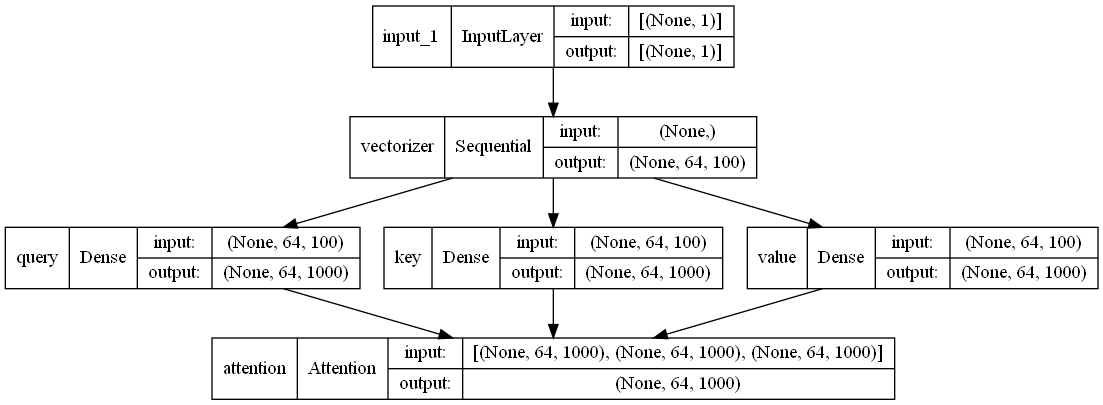

In [13]:
## encoder
vectorize=Sequential(name="vectorizer")
vectorize.add(input_text_processor)
vectorize.add(Embedding(100,100))

input=Input(shape=(1,),dtype=tf.string)
model=vectorize(input)
query=Dense(1000,name="query")(model)
key=Dense(1000,name="key")(model)
value=Dense(1000,name="value")(model)
attention=Attention()([query,key,value])

model=Model(input,attention,name="Encoder")

model.summary()
plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
)

In [14]:
## decoder -> to take it easy it's just a two dense layer with vocab_dim

input=Input(shape=(output_sequence_length,1000))
d=Dense(1000)(input)
d=Activation("relu")(d)
d=Dense(max_vocab_size)(d)
d=Activation("softmax")(d)

decoder=Model(input,d,name="decoder")

In [15]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
            
        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)

In [24]:
###
class Translator(tf.keras.Model):
    def __init__(self,input_text_processor,output_text_processor,encoder,decoder):
        super().__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        self.input_text_processor=input_text_processor
        self.output_text_processor=output_text_processor
        
        
        
        
    def _preprocess(self, input_text, target_text):


        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)


        # Convert IDs to masks.
        input_mask = input_tokens != 0


        target_mask = target_tokens != 0

        return input_tokens, input_mask, target_tokens, target_mask


    def train_step(self,inputs):
        input_text, target_text = inputs
        
        (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)
        max_target_length = tf.shape(target_tokens)[1]
        
        with tf.GradientTape() as tape:
            encoded=self.encoder(input_text)
            
            #basic 
            decoded=self.decoder(encoded)
            
            loss=self.loss(target_tokens,decoded)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients,self.trainable_weights))
        
        return {"loss":loss}
    
    def call(self,inputs):
        input_text, target_text = inputs
        
        (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)
        max_target_length = tf.shape(target_tokens)[1]
        encoded=self.encoder(input_text)
        decoded=self.decoder(encoded)
        
        return decoded
    
    def translate(self,inputs):
        
        ## campionare!
        
        encoded=self.encoder(inputs)
        decoded=self.decoder(encoded)
        #print(f"DEBUG {decoded.shape}")
        tran_list=[]
        out_list=[]
        for b in decoded:
            for token in b:
                tran_list.append(self.output_text_processor.get_vocabulary()[np.argmax(token)])
                output=" ".join(tran_list)
            out_list.append(output)
        return out_list

In [25]:
translator = Translator(input_text_processor,output_text_processor,model,decoder)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [18]:
translator.fit(dataset,epochs=3)
#translator.load_weights("prova_traduzione.tf")

Epoch 1/3


c:\users\matte\anaconda3\envs\ai_env\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5501/5501 [==============================] - 271s 49ms/step - loss: 1915.6654
Epoch 2/3
5501/5501 [==============================] - 308s 56ms/step - loss: 1601.1110
Epoch 3/3
5501/5501 [==============================] - 312s 57ms/step - loss: 1504.5315


In [19]:
translator.save_weights("prova_traduzione.tf",save_format="tf")
translator.load_weights("prova_traduzione.tf")

In [27]:
#decifrate

frase=tf.constant("Ho molta fame e fa freddo.")

y=translator.translate(tf.expand_dims(frase,0))

y

['[START] i the the and the the . . [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END] [END]']

In [ ]:
len(y)